# Stacking Late Fusion model - InceptionV3 + BERT/LSTM

In [ ]:
# Install BERT for tf2 module
!pip install bert-for-tf2
# Install Keras version 2.3.1
!pip install keras==2.3.1

In [ ]:
# Import all necessary libraries
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import bert

import numpy as np 
import pandas as pd
import re
import glob
import os
import cv2
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Import the training and test .csv files
colnames=['image_path', 'text', 'food']
train = pd.read_csv('train_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])
test = pd.read_csv('test_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])

In [ ]:
# Sort values by 'image_path'
test = test.sort_values('image_path')
train = train.sort_values('image_path')

In [ ]:
print(train.shape)
train.head()

(67972, 2)


text       food
image_path                                                                     
apple_pie_851.jpg    Crock-Pot Ladies  Crock-Pot Apple Pie Moonshine  apple_pie
apple_pie_140.jpg       Mom's Maple-Apple Pie Recipe | Taste of Home  apple_pie
apple_pie_858.jpg  Cookin&#8217; Canuck &#8211; Baked Apple Pie E...  apple_pie
apple_pie_449.jpg      Dutch Apple Pie Recipe | Just A Pinch Recipes  apple_pie
apple_pie_695.jpg  Our Share of the Harvest &raquo; Grandma&#8217...  apple_pie

In [ ]:
def get_missing(file, df):
  parts = file.split(os.sep)
  idx = parts[-1]
  cls = parts[-2]
  indexes = df[:,0]
  classes = df[:,2]

  if idx in indexes:
    text = df[idx == indexes][0,1]
    return pd.NA, pd.NA, pd.NA
  else:
    text = df[cls == classes][0,1]
    
  return idx, text, cls   

vec_get_missing = np.vectorize(get_missing, signature='(),(m,n)->(),(),()') 

In [ ]:
# Function for images loading

def add_not_found(path, df):
  files = glob.glob(path)
  df = df.reset_index()
  idxs, texts, cls = vec_get_missing(files, df.values)
  
  found = pd.DataFrame({"text": texts,
                        "food": cls,
                       "image_path": idxs})
  na = found.isna().sum().values[0]
  if na<found.shape[0]:
    df = df.append(found)
  df = df.drop_duplicates(subset='image_path', keep='first').dropna()
  df = df.set_index('image_path')
  df = shuffle(df, random_state = 0)
  return df      

In [ ]:
# Images folders 
train = add_not_found('images/train/*/*.jpg', train)
test = add_not_found('images/test/*/*.jpg', test)

print("Number of training images:",train.shape[0])
print("Number of test images:",test.shape[0])

train samples: 67988
test samples: 22716


In [ ]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
# Preprocessing of texts according to BERT +
# Cleaning of the textst

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

def get_tokens(text, tokenizer):
  tokens = tokenizer.tokenize(text)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  length = len(tokens)
  if length > max_length:
      tokens = tokens[:max_length]
  return tokens, length  

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    image_name = parts[-1]
    is_train = parts[-3] == 'train'
    if is_train:
      df = train
    else:
      df = test

    text = df['text'][image_name]
    return text
vec_get_text = np.vectorize(get_texts)
def prepare_text(paths):
    #Preparing texts
    
    texts = vec_get_text(paths)
    
    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)
    
    return ids, segments, masks

def clean(i, tokens):
  try:
    this_token = tokens[i]
    next_token = tokens[i+1]
  except:
    return tokens
  if '##' in next_token:
      tokens.remove(next_token)
      tokens[i] = this_token + next_token[2:]
      tokens = clean(i, tokens)
      return tokens
  else:
    i = i+1
    tokens = clean(i, tokens)
    return tokens

def clean_text(array):
  array = array[(array!=0) & (array != 101) & (array != 102)]
  tokens = tokenizer.convert_ids_to_tokens(array)
  tokens = clean(0, tokens)
  text = ' '.join(tokens)
  return text

In [ ]:
# Images preprocessing
def load_image(path):
    path = path.decode('utf-8')
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height))
    image = image/255
    image = image.astype(np.float32)
    parts = path.split(os.sep)
    labels = parts[-2] == Classes 
    labels = labels.astype(np.int32)
    
    return image, labels
    
vec_load_image = np.vectorize(load_image, signature = '()->(r,c,d),(s)')

In [ ]:
# Dataset creation

def prepare_data(paths):
    #Images and labels
    images, labels = tf.numpy_function(vec_load_image, 
                                      [paths], 
                                      [tf.float32, 
                                        tf.int32])
    
    
    [ids, segments, masks, ] = tf.numpy_function(prepare_text, 
                                              [paths], 
                                              [tf.int32, 
                                               tf.int32,
                                               tf.int32])
    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids, 
             "input_mask": masks,  
             "segment_ids": segments, 
             "image": images},
            {"class": labels})
    

    return dataset

In [ ]:
# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  80
img_width = 299
img_height = 299
depth = 3
max_length = 20 #Setup according to the text

nClasses = train.food.nunique()
Classes = train.food.unique()
input_shape = (img_width, img_height, depth)

In [ ]:
# Images loading using tf.data
def tf_data(path, batch_size):
    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    return dataset   
data_train = tf_data('images/train/*/*.jpg', batch_size)
data_test = tf_data('images/test/*/*.jpg', batch_size)

In [ ]:
ip, op = next(iter(data_train))
images = ip['image'][:16]
input_word_ids = ip['input_word_ids'][:16]
true_labels =  op['class'][:16]

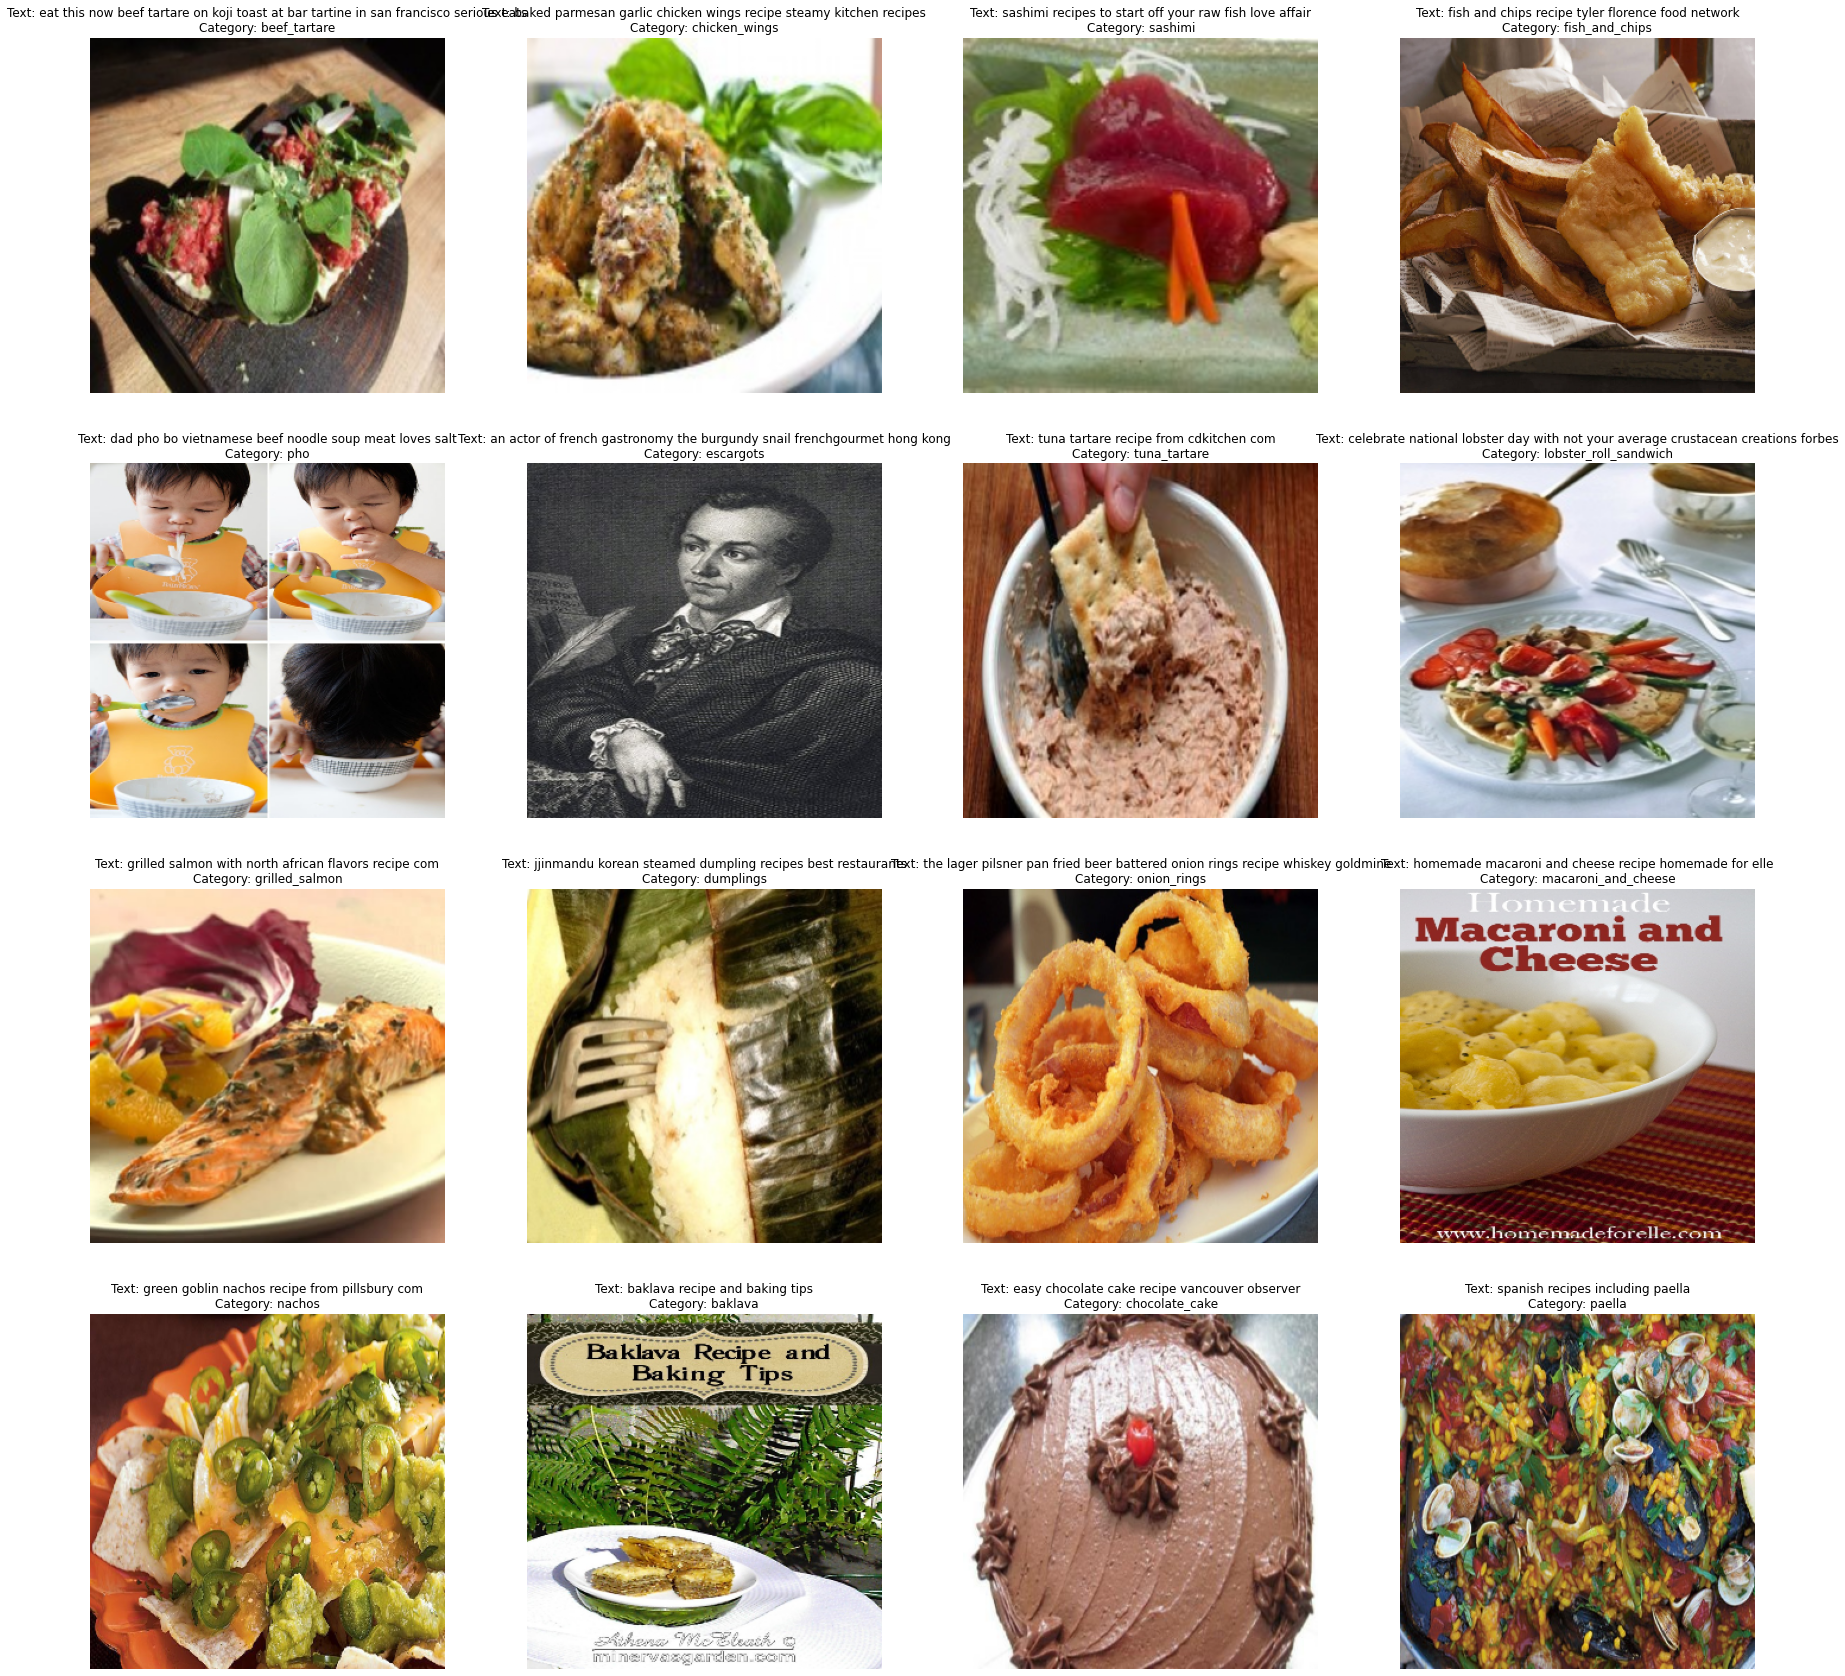

In [ ]:
# Print images and related texts before classification
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()]
plt.figure(figsize=(30,30))
for image, label, text in zip(images.numpy(), true_labels.numpy(), texts):
      plt.subplot(4,4,i)
      i+=1
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.axis('off')
      plt.title("Text: {}\nCategory: {}".format(text, Classes[label.argmax(0)]))
plt.show()

In [ ]:
# Images Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
x = base_model.output
x = layers.AveragePooling2D(pool_size=(8, 8))(x)
x = layers.Dropout(.4)(x)
x = layers.Flatten()(x)

predictions = layers.Dense(nClasses,
                    kernel_regularizer=l2(0.005),
                    activity_regularizer=l1(0.005), 
                    activation='softmax')(x)

model_cnn = models.Model(base_model.input, predictions, name='Image_Model')


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Load Images model weights
model_cnn.load_weights('stacking_late_fusion/InceptionV3.hdf5')

In [ ]:
# Freeze the images model layers
for layer in model_cnn.layers:
    layer.trainable = False

In [ ]:
# Bert + LSTM model
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='Images')
input_masks = layers.Input(shape=(max_length,), dtype=tf.int32)
input_segments = layers.Input(shape=(max_length,), dtype=tf.int32)
_, seq_out = bert_layer([input_ids, input_masks, input_segments])

X = layers.LSTM(128)(seq_out)
X = layers.Dense(256, activation="relu")(X)
out = layers.Dense(nClasses, activation = 'softmax')(X)
model_lstm = models.Model([input_ids, input_masks, input_segments], out, name='Bert_Model')

In [ ]:
# Freeze the Bert + LSTM layers
for layer in model_lstm.layers:
    layer.trainable = False

In [ ]:
# Load BERT + LSTM model weights
model_lstm.load_weights('stacking_late_fusion/BERT-LSTM-0.84.hdf5')

In [ ]:
# Multimodal Late Fusion Model
input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                           name = "image")

image_side = model_cnn(image_input)
text_side = model_lstm([input_word_ids, input_mask, segment_ids])
# Concatenation
merged = layers.Concatenate(name='Concatenation')([image_side, text_side])
merged = layers.Dense(256, activation = 'relu', name='Dense_256')(merged)
merged = layers.Dropout(0.2)(merged)
merged = layers.Dense(128, activation = 'relu', name='Dense_128')(merged)
merged = layers.Dropout(0.2)(merged)
output = layers.Dense(nClasses, activation='softmax', name = "class")(merged)

In [ ]:
model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
______________________________________________________________________________________________

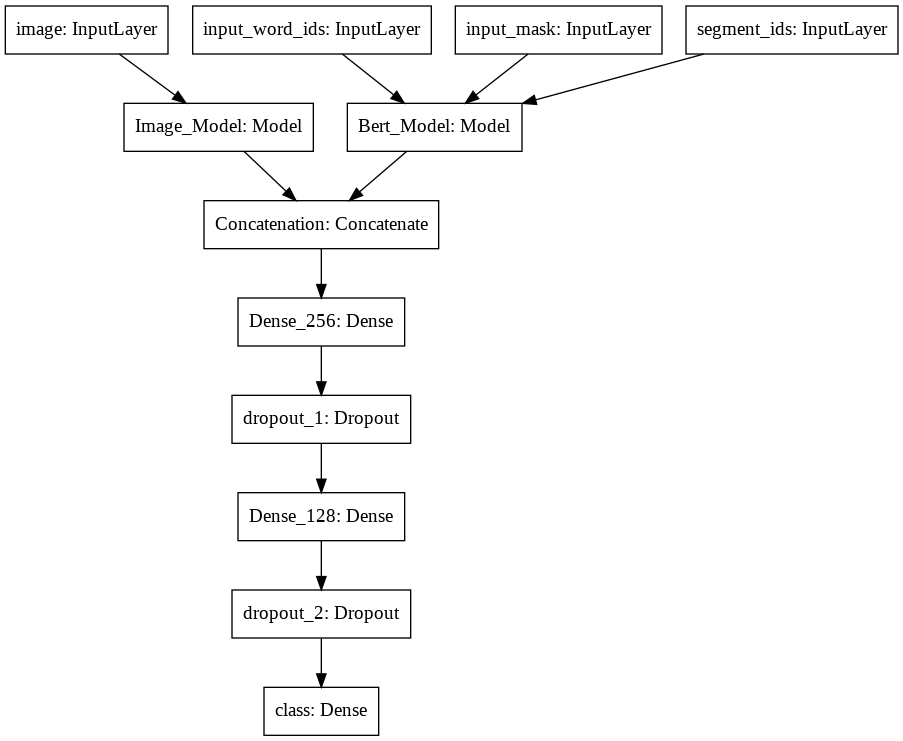

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multimodal.png')

In [ ]:
# Stochastic Gradient Descent optimizer
sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

In [ ]:
# Setup callbacks, logs and early stopping condition
checkpoint_path = "stacking_late_fusion/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True,verbose=1, mode='max')
csv_logger = callbacks.CSVLogger('stacking_late_fusion/stacking_early.log')
es = callbacks.EarlyStopping(patience = 3, restore_best_weights=True)

In [ ]:
# Reduce learning rate if no improvement is observed
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [ ]:
# Load model weights
model.load_weights('stacking_late_fusion/weights-improvement-02-0.80.hdf5')

In [ ]:
# Training
#history = model.fit(data_train,
#                    epochs=15,
#                    steps_per_epoch = train.shape[0]//batch_size,
#                    validation_data = data_test,
#                    validation_steps = test.shape[0]//batch_size,
#                    callbacks=[cp, csv_logger, reduce_lr])

Epoch 1/10
971/971 [==============================] - ETA: 0s - loss: 3.6385 - accuracy: 0.5512
Epoch 00001: val_accuracy improved from -inf to 0.84563, saving model to /content/drive/My Drive/Colab Notebooks/probability_2/weights-improvement-01-0.85.hdf5
971/971 [==============================] - 1436s 1s/step - loss: 3.6385 - accuracy: 0.5512 - val_loss: 1.3533 - val_accuracy: 0.8456 - lr: 0.0100
Epoch 2/10
971/971 [==============================] - ETA: 0s - loss: 0.9235 - accuracy: 0.8800
Epoch 00002: val_accuracy did not improve from 0.84563
971/971 [==============================] - 1424s 1s/step - loss: 0.9235 - accuracy: 0.8800 - val_loss: 1.0132 - val_accuracy: 0.8447 - lr: 0.0100
Epoch 3/10
971/971 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.8835
Epoch 00003: val_accuracy did not improve from 0.84563
971/971 [==============================] - 1423s 1s/step - loss: 0.7898 - accuracy: 0.8835 - val_loss: 1.0192 - val_accuracy: 0.8451 - lr: 0.0100
Epoc

In [ ]:
# Plot training and test accuracy using Plotly library
df = pd.read_csv('stacking_late_fusion/stacking_early.log')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Plot training and test loss using Plotly library
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Model evaluation on test set
model.evaluate(data_test,
               steps = test.shape[0]//batch_size)

283/283 [==============================] - 176s 621ms/step - loss: 1.6759 - accuracy: 0.7965


[1.6759432554244995, 0.7964664101600647]

**Plot some predictions**

In [ ]:
ip, op = next(iter(data_test))
images = ip['image'][:16]

input_masks = ip['input_mask'][:16]
input_word_ids = ip['input_word_ids'][:16]
input_segments = ip['segment_ids'][:16]

true_labels =  op['class'][:16]

In [ ]:
pred_labels = model.predict([input_word_ids,
                             input_masks,
                             input_segments,
                             images])

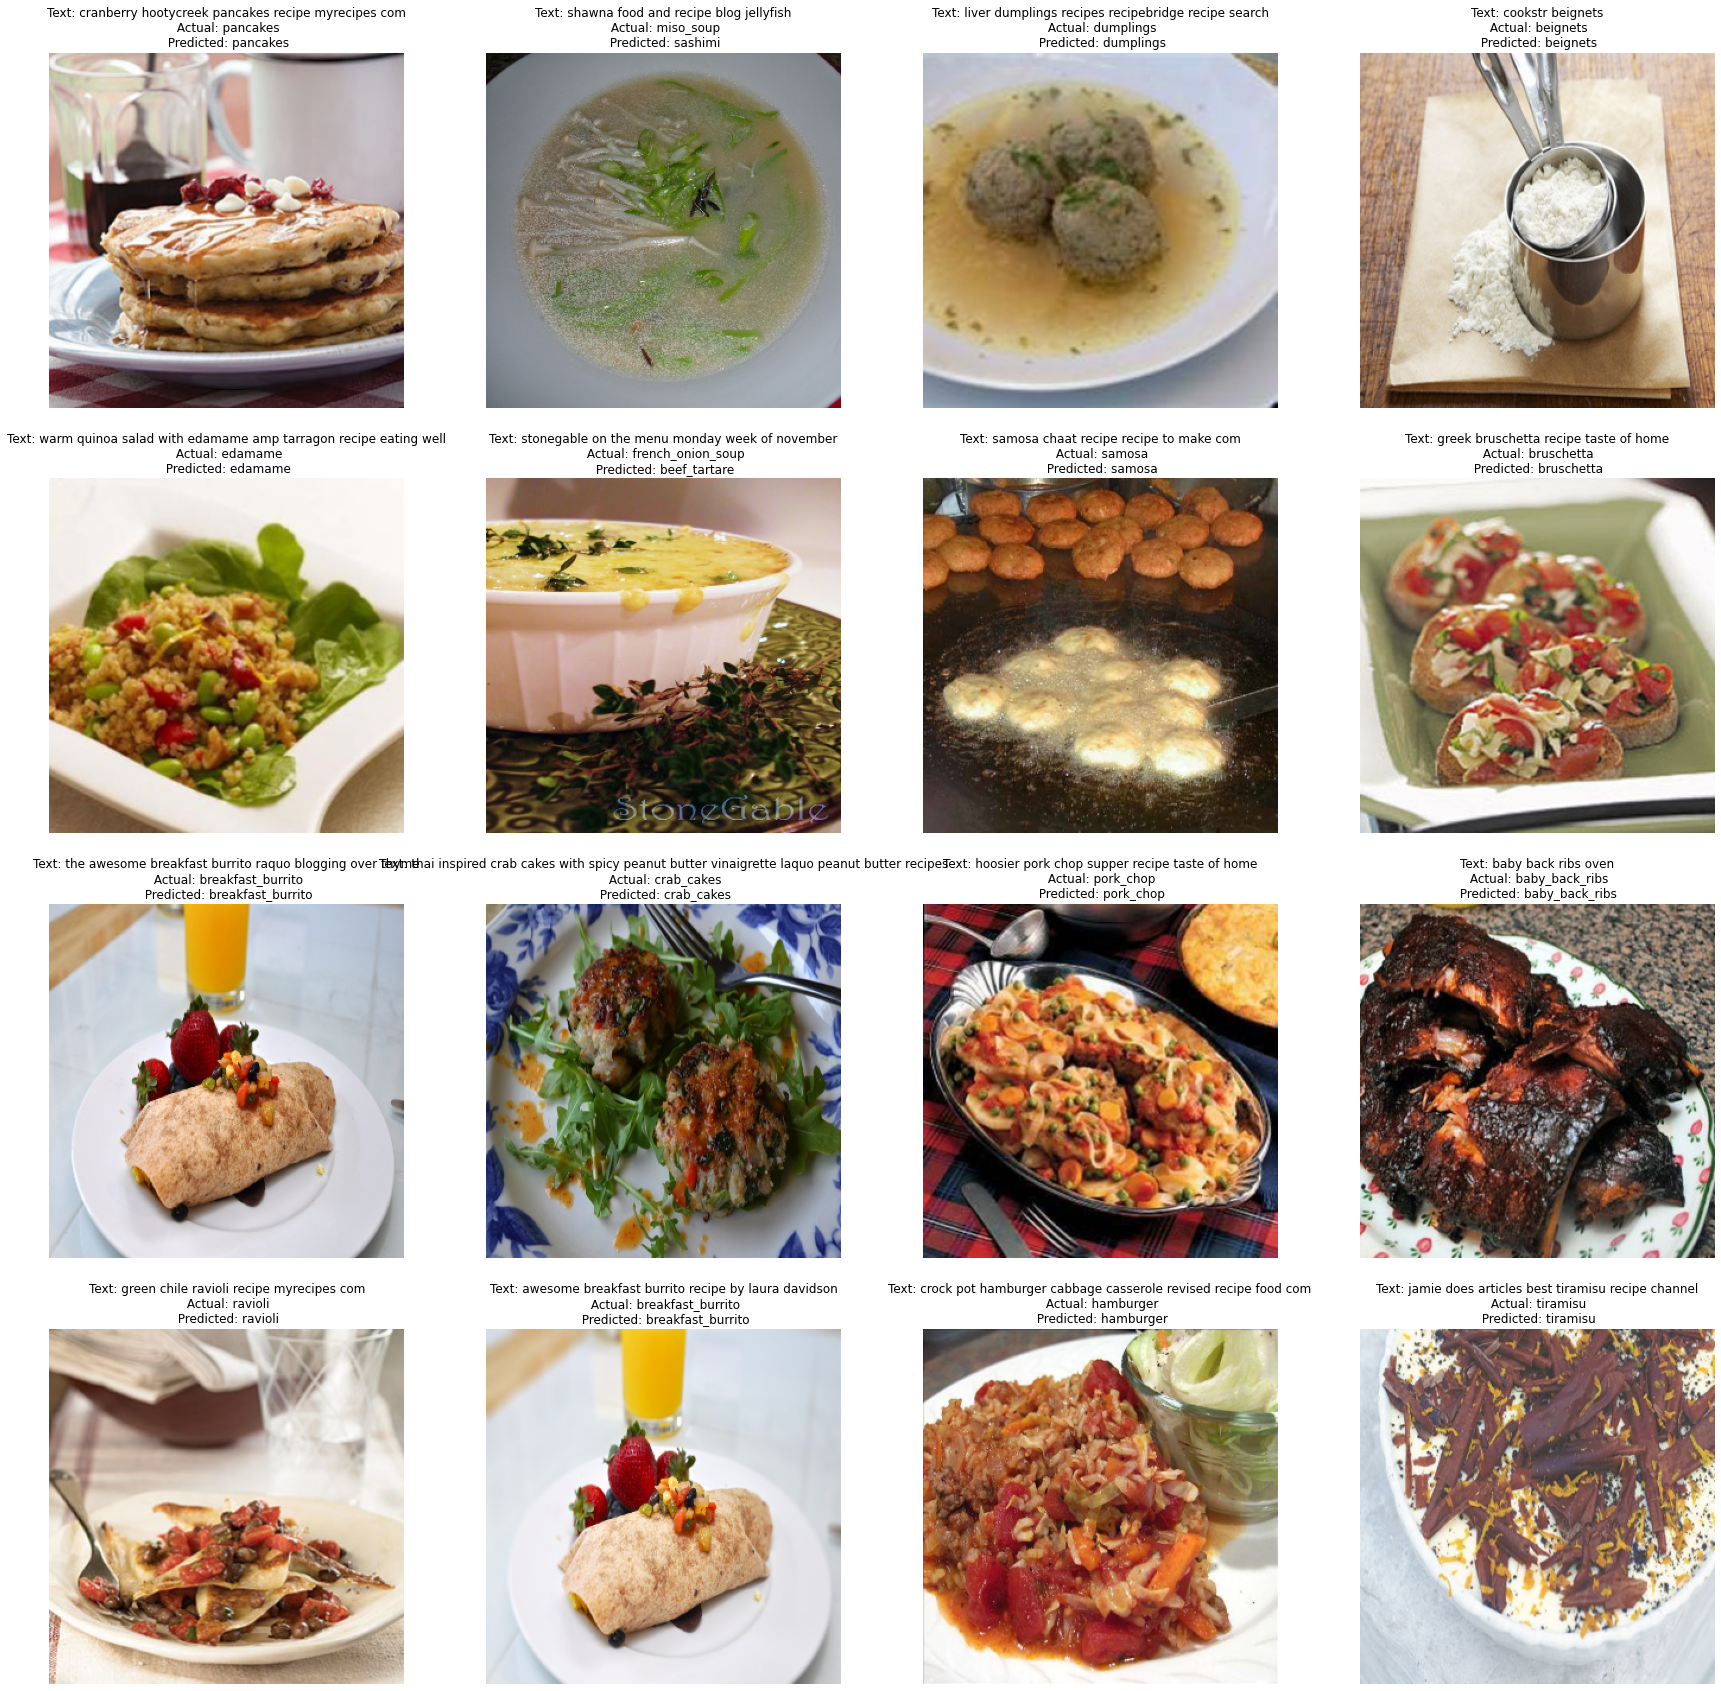

In [ ]:
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()[:16]]
plt.figure(figsize=(30,30))
for image, actual_label, label, text in zip(images.numpy()[:16], true_labels.numpy()[:16], pred_labels, texts):
      plt.subplot(4,4,i)
      i+=1
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.axis('off')
      plt.title("Text: {}\n Actual: {}\n Predicted: {}".format(text, Classes[actual_label.argmax(0)], Classes[label.argmax(0)]))
      plt.xlabel(text)
plt.show()